In [35]:
from qiskit import transpile
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from matplotlib import pyplot as plt

sim = AerSimulator()

## Simulating using estimator

In [3]:
from qiskit_aer.primitives import EstimatorV2

In [4]:
psi1 = transpile(RealAmplitudes(num_qubits=2, reps=2), sim, optimization_level=0)
psi2 = transpile(RealAmplitudes(num_qubits=2, reps=3), sim, optimization_level=0)

H1 = SparsePauliOp.from_list([("II", 1), ("IZ", 2), ("XI", 3)])
H2 = SparsePauliOp.from_list([("IZ", 1)])
H3 = SparsePauliOp.from_list([("ZI", 1), ("ZZ", 1)])

theta1 = [0, 1, 1, 2, 3, 5]
theta2 = [0, 1, 1, 2, 3, 5, 8, 13]
theta3 = [1, 2, 3, 4, 5, 6]

estimator = EstimatorV2()

# calculate [ [<psi1(theta1)|H1|psi1(theta1)>,
#              <psi1(theta3)|H3|psi1(theta3)>],
#             [<psi2(theta2)|H2|psi2(theta2)>] ]
job = estimator.run(
    [
        (psi1, [H1, H3], [theta1, theta3]),
        (psi2, H2, theta2)
    ],
    precision=0.01
)
result = job.result()
print(f"expectation values : psi1 = {result[0].data.evs}, psi2 = {result[1].data.evs}")



expectation values : psi1 = [ 1.55129001 -1.09764033], psi2 = 0.19399837062350367


## Simulating using sampler

In [42]:
from qiskit_aer.primitives import SamplerV2
from qiskit import QuantumCircuit
import math

In [43]:
# create a Bell circuit
bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
bell.measure_all()

# create two parameterized circuits
pqc = RealAmplitudes(num_qubits=2, reps=2)
pqc.measure_all()
pqc = transpile(pqc, sim, optimization_level=0)
pqc2 = RealAmplitudes(num_qubits=2, reps=3)
pqc2.measure_all()
pqc2 = transpile(pqc2, sim, optimization_level=0)

theta1 = [math.pi/2, 1, 1, 2, 3, 5]
theta2 = [0, 1, 2, 3, 4, 5, 6, 7]

# initialization of the sampler
sampler = SamplerV2()

# collect 128 shots from the Bell circuit
job = sampler.run([bell], shots=128)
job_result_bell = job.result()
print(f"counts for Bell circuit : {job_result[0].data.meas.get_counts()}")
 
# run a sampler job on the parameterized circuits
job2 = sampler.run([(pqc, theta1), (pqc2, theta2)])
job_result_parameterized = job2.result()
print(f"counts for parameterized circuit : {job_result[0].data.meas.get_counts()}")

counts for Bell circuit : {'01': 367, '10': 95, '00': 133, '11': 429}
counts for parameterized circuit : {'01': 367, '10': 95, '00': 133, '11': 429}


### Plotting

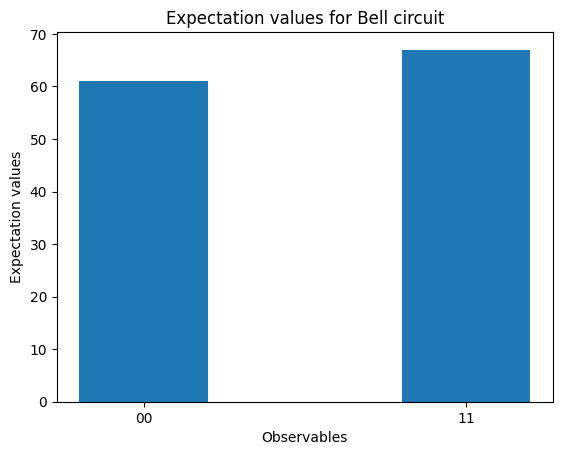

In [47]:
data = job_result_bell[0].data.meas.get_counts().keys()
values = job_result_bell[0].data.meas.get_counts().values()


plt.bar(data, values, width=0.4)
plt.xlabel('Observables')
plt.ylabel('Expectation values')
plt.title('Expectation values for Bell circuit')
plt.show()

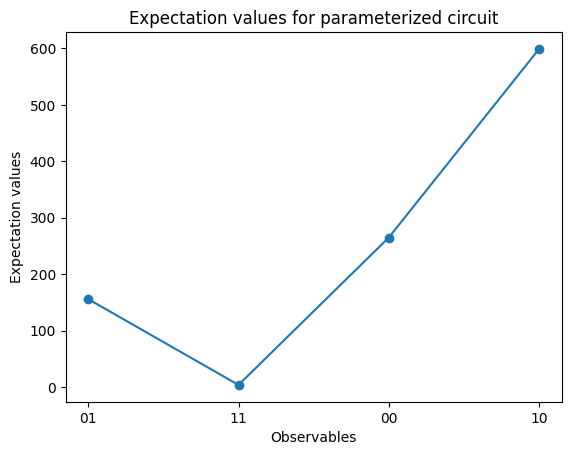

In [48]:
data = job_result_parameterized[0].data.meas.get_counts().keys()
values = job_result_parameterized[0].data.meas.get_counts().values()


plt.plot(data, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Expectation values')
plt.title('Expectation values for parameterized circuit')
plt.show()

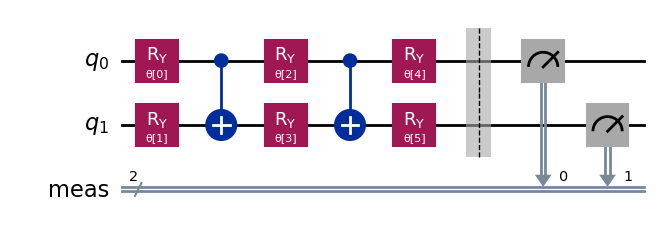

In [10]:
pqc.draw(output='mpl')

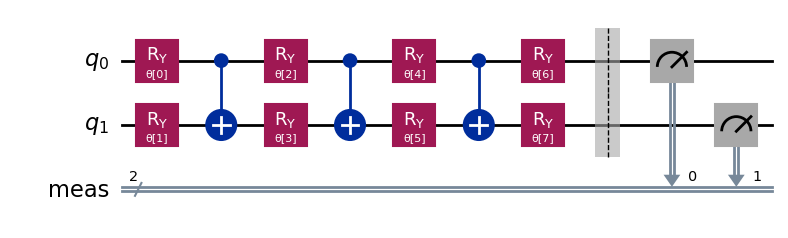

In [11]:
pqc2.draw(output='mpl')

## Simulating with noise model from actual hardware

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [6]:
provider = QiskitRuntimeService(channel='ibm_quantum', token="set your own token here")
backend = provider.get_backend("ibm_kyoto")

# create sampler from the actual backend
sampler = SamplerV2.from_backend(backend)

# run a sampler job on the parameterized circuits with noise model of the actual hardware
bell_t = transpile(bell, AerSimulator(basis_gates=["ecr", "id", "rz", "sx"]), optimization_level=0)
job3 = sampler.run([bell_t], shots=128)
job_result = job3.result()
print(f"counts for Bell circuit w/noise: {job_result[0].data.meas.get_counts()}")

IBMNotAuthorizedError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'